<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/notebooks/2020%E2%88%921006PyTorch_transfer_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

# 転移学習
**著者**: [Sasank Chilamkurthy](https://chsasank.github.io)

転移学習の詳細については，ビデオ講義を参照してください。
または，[cs231n notes](https://cs231n.github.io/transfer-learning/) を御覧ください。

実際には，十分なサイズのデータセットを持っていることは比較的稀であす。
このため，大規模な畳み込みニューラルネットワーク全体をゼロから（ランダムな初期化を行って）訓練する人はほとんどいません．その代わりに，大規模なデータセット（例えば，1000のカテゴリを持つ120万枚の画像を含む ImageNet など）で 畳み込みニューラルネットワークを事前に訓練しておき，そのネットワークを初期化したり，目的の課題固有の特徴抽出器として使用する方法が試みられています。

2 方法があります。

- **ファインチューニング**: 
Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
- **転移学習**: 
Here, we will freeze the weights for all of the network except that of the final fully connected layer. 
This last fully connected layer is replaced with a new one with random weights and only this layer is trained.




In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## データの読み込み

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

Note ::
Download the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it to the current directory.



In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images

Let's visualize a few training images so as to understand the dataaugmentations.



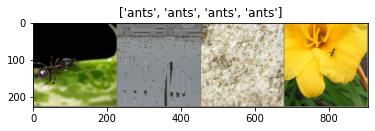

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1), end=" ")
        #print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc), end=" ")

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.




In [ ]:
%time
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_ft)

## 転移学習の例

Here, we need to freeze all the network except the final layer. We need to set ``requires_grad == False`` to freeze the parameters so that the gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)




In [ ]:
model_transfer_learning = torchvision.models.resnet18(pretrained=True)
for param in model_transfer_learning.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_transfer_learning.fc.in_features
model_transfer_learning.fc = nn.Linear(num_ftrs, 2)

model_transfer_learning = model_transfer_learning.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_transfer_learning = optim.SGD(model_transfer_learning.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_transfer_learning, step_size=7, gamma=0.1)

#### 訓練と評価

In [ ]:
%time
model_transfer_learing = train_model(model_transfer_learning, criterion, optimizer_transfer_learning, exp_lr_scheduler, num_epochs=20)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
Epoch 0/19 train Loss: 0.6111 Acc: 0.7213 val Loss: 0.2180 Acc: 0.9412 
Epoch 1/19 train Loss: 0.4643 Acc: 0.7705 val Loss: 0.1958 Acc: 0.9412 
Epoch 2/19 train Loss: 0.4775 Acc: 0.7951 val Loss: 0.2671 Acc: 0.8954 
Epoch 3/19 train Loss: 0.4164 Acc: 0.7992 val Loss: 0.1683 Acc: 0.9346 
Epoch 4/19 train Loss: 0.8225 Acc: 0.6967 val Loss: 0.1759 Acc: 0.9346 
Epoch 5/19 train Loss: 0.4463 Acc: 0.8115 val Loss: 0.2479 Acc: 0.9216 
Epoch 6/19 train Loss: 0.7170 Acc: 0.7500 val Loss: 0.1549 Acc: 0.9542 
Epoch 7/19 train Loss: 0.4961 Acc: 0.7705 val Loss: 0.1737 Acc: 0.9477 
Epoch 8/19 train Loss: 0.3608 Acc: 0.8402 val Loss: 0.1632 Acc: 0.9477 
Epoch 9/19 train Loss: 0.3656 Acc: 0.8484 val Loss: 0.1778 Acc: 0.9477 
Epoch 10/19 train Loss: 0.3536 Acc: 0.8443 val Loss: 0.1687 Acc: 0.9477 
Epoch 11/19 train Loss: 0.3839 Acc: 0.8320 val Loss: 0.1821 Acc: 0.9477 
Epoch 12/19 train Loss: 0.2779 Acc: 0.8811 val Loss: 0.1685 Acc: 0

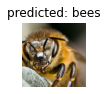

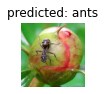

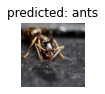

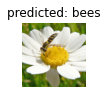

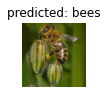

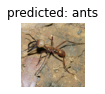

In [ ]:
visualize_model(model_transfer_learning)

plt.ioff()
plt.show()

# ファインチューニングの例


In [ ]:
model_finetuning = models.resnet18(pretrained=True)
num_ftrs = model_finetuning.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_finetuning = model_finetuning.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_finetuning = optim.SGD(model_finetuning.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_finetuning, step_size=7, gamma=0.1)

In [ ]:
%time
model_finetuning = train_model(model_finetuning, criterion, optimizer_finetuning, exp_lr_scheduler, num_epochs=25)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Epoch 0/24 train Loss: 1.6963 Acc: 0.6352 val Loss: 1.4044 Acc: 0.6601 
Epoch 1/24 train Loss: 0.7226 Acc: 0.7336 val Loss: 0.3480 Acc: 0.8562 
Epoch 2/24 train Loss: 0.6490 Acc: 0.7623 val Loss: 0.6169 Acc: 0.7582 
Epoch 3/24 train Loss: 0.7498 Acc: 0.7377 val Loss: 0.9696 Acc: 0.7712 
Epoch 4/24 train Loss: 0.7779 Acc: 0.7500 val Loss: 0.8214 Acc: 0.7516 
Epoch 5/24 train Loss: 0.5405 Acc: 0.7459 val Loss: 0.3739 Acc: 0.8431 
Epoch 6/24 train Loss: 0.5656 Acc: 0.7541 val Loss: 0.4580 Acc: 0.8170 
Epoch 7/24 train Loss: 0.4070 Acc: 0.8197 val Loss: 0.2565 Acc: 0.8954 
Epoch 8/24 train Loss: 0.3886 Acc: 0.8402 val Loss: 0.2507 Acc: 0.9085 
Epoch 9/24 train Loss: 0.3785 Acc: 0.8484 val Loss: 0.2413 Acc: 0.9085 
Epoch 10/24 train Loss: 0.3016 Acc: 0.8770 val Loss: 0.2614 Acc: 0.8889 
Epoch 11/24 train Loss: 0.3286 Acc: 0.8770 val Loss: 0.2449 Acc: 0.9020 
Epoch 12/24 train Loss: 0.2770 Acc: 0.8934 val Loss: 0.2392 Acc: 0.908

In [ ]:
# モデルの構造を表示します
model_finetuning

In [ ]:
visualize_model(model_finetuning)

## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html)



